Symbolic execution
1. Parse the code into a DAG
2. Collect all the conditions in every path
3. Solve it using Z3

In [5]:
def getMaxValue(a,b,c):
    a = 1
    b = 3
    c = 4
    a = a+1
    if b*b>c*c:
        print("Hello","World")
    else:
        print("bla")
    z1 = 2

In [6]:
import dis
dis.dis(getMaxValue)

  2           0 LOAD_CONST               1 (1)
              2 STORE_FAST               0 (a)

  3           4 LOAD_CONST               2 (3)
              6 STORE_FAST               1 (b)

  4           8 LOAD_CONST               3 (4)
             10 STORE_FAST               2 (c)

  5          12 LOAD_FAST                0 (a)
             14 LOAD_CONST               1 (1)
             16 BINARY_ADD
             18 STORE_FAST               0 (a)

  6          20 LOAD_FAST                1 (b)
             22 LOAD_FAST                1 (b)
             24 BINARY_MULTIPLY
             26 LOAD_FAST                2 (c)
             28 LOAD_FAST                2 (c)
             30 BINARY_MULTIPLY
             32 COMPARE_OP               4 (>)
             34 POP_JUMP_IF_FALSE       48

  7          36 LOAD_GLOBAL              0 (print)
             38 LOAD_CONST               4 ('Hello')
             40 LOAD_CONST               5 ('World')
             42 CALL_FUNCTION            2
   

In [7]:
z = dis.Bytecode(getMaxValue)

In [8]:
print(z)

Bytecode(<function getMaxValue at 0x10a23d550>)


In [9]:
edges = []
nodes = []
prevInstructionIsJump = False
for instr in z:
    # Adding edges
    if prevInstructionIsJump:
        edges.append((nodes[-1],instr.offset))
    if "JUMP" in instr.opname:
        edges.append((nodes[-1],int(instr.argval)))
    # Adding nodes
    if instr.is_jump_target:
        nodes.append(instr.offset)
    if prevInstructionIsJump:
        nodes.append(instr.offset)
    if instr.offset == 0:
        nodes.append(instr.offset)
    print(instr.offset,instr.opname,instr.arg,instr.argval,instr.is_jump_target)
    if "JUMP" in instr.opname:
        prevInstructionIsJump = True
    else:
        prevInstructionIsJump = False

nodes = list(set(nodes))
nodes.sort()
edges = list(set(edges))

print(nodes,edges)

0 LOAD_CONST 1 1 False
2 STORE_FAST 0 a False
4 LOAD_CONST 2 3 False
6 STORE_FAST 1 b False
8 LOAD_CONST 3 4 False
10 STORE_FAST 2 c False
12 LOAD_FAST 0 a False
14 LOAD_CONST 1 1 False
16 BINARY_ADD None None False
18 STORE_FAST 0 a False
20 LOAD_FAST 1 b False
22 LOAD_FAST 1 b False
24 BINARY_MULTIPLY None None False
26 LOAD_FAST 2 c False
28 LOAD_FAST 2 c False
30 BINARY_MULTIPLY None None False
32 COMPARE_OP 4 > False
34 POP_JUMP_IF_FALSE 48 48 False
36 LOAD_GLOBAL 0 print False
38 LOAD_CONST 4 Hello False
40 LOAD_CONST 5 World False
42 CALL_FUNCTION 2 2 False
44 POP_TOP None None False
46 JUMP_FORWARD 8 56 False
48 LOAD_GLOBAL 0 print True
50 LOAD_CONST 6 bla False
52 CALL_FUNCTION 1 1 False
54 POP_TOP None None False
56 LOAD_CONST 7 2 True
58 STORE_FAST 3 z1 False
60 LOAD_CONST 0 None False
62 RETURN_VALUE None None False
[0, 36, 48, 56] [(36, 56), (0, 36), (0, 48), (36, 48)]


In [10]:
dis.dis(getMaxValue)

  2           0 LOAD_CONST               1 (1)
              2 STORE_FAST               0 (a)

  3           4 LOAD_CONST               2 (3)
              6 STORE_FAST               1 (b)

  4           8 LOAD_CONST               3 (4)
             10 STORE_FAST               2 (c)

  5          12 LOAD_FAST                0 (a)
             14 LOAD_CONST               1 (1)
             16 BINARY_ADD
             18 STORE_FAST               0 (a)

  6          20 LOAD_FAST                1 (b)
             22 LOAD_FAST                1 (b)
             24 BINARY_MULTIPLY
             26 LOAD_FAST                2 (c)
             28 LOAD_FAST                2 (c)
             30 BINARY_MULTIPLY
             32 COMPARE_OP               4 (>)
             34 POP_JUMP_IF_FALSE       48

  7          36 LOAD_GLOBAL              0 (print)
             38 LOAD_CONST               4 ('Hello')
             40 LOAD_CONST               5 ('World')
             42 CALL_FUNCTION            2
   

In [11]:
from dis import Instruction
from typing import List
import math
class Node:
    def __init__(self, nodeId_,instructions_: List[Instruction],children_: List['Node']=None):
        if children_ is None:
            children_ = []
        self.children = children_
        self.nodeId = nodeId_
        self.instructions = instructions_

nodeIdToGraphObjectMapping = {}
for i in range(len(nodes)):
    start = nodes[i]
    # If i is the last node
    if i+1==len(nodes):
        end = math.inf
    else:
        end = nodes[i+1]
    instructions = []
    nodeId = start
    for instr in z:
        if start <= instr.offset < end:
            instructions.append(instr)
    nodeIdToGraphObjectMapping[nodeId] = Node(nodeId,instructions)

for (nodeId1,nodeId2) in edges:
    nodeIdToGraphObjectMapping[nodeId1].children.append(nodeIdToGraphObjectMapping[nodeId2])

root = nodeIdToGraphObjectMapping[0]



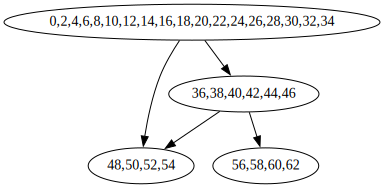

In [12]:
from graphviz import Digraph
gra = Digraph()
# print(nodeIdToGraphObjectMapping)
# str(nodeIdToGraphObjectMapping[0].instructions
for (nodeId,node) in nodeIdToGraphObjectMapping.items():
    gra.node(str(nodeId),str(",".join([str(instr.offset) for instr in node.instructions])))
for (nodeId,node) in nodeIdToGraphObjectMapping.items():
    for child in node.children:
        gra.edge(str(nodeId),str(child.nodeId))
#
gra

In [13]:
from collections import deque


# def DFS(currentNode:Node,executionStack:deque,mapVersionedVariables,mapLatestVersionForVariable):
#     for instr_ in currentNode.instructions:
#         match str(instr_.opname):
#             case "LOAD_CONST":
#                 executionStack.append(instr.argval)
#             case "STORE_FAST":
#                 var = str(instr.argval)
#                 if var in mapVersionedVariables:
#
#                 executionStack.pop()